In [28]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from transformers import AutoImageProcessor, ViTModel, ViTForImageClassification #, AutoModel, AutoProcessor
import torch
from datasets import load_dataset
from PIL import Image


In [29]:


dataset = load_dataset("huggingface/cats-image")
image = dataset["test"]["image"][0]
# image = Image.open(r"D:\val2017\000000000285.jpg") # TODO: change to your image path

# image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224-in21k")
# model = ViTModel.from_pretrained("google/vit-base-patch16-224-in21k")
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")

inputs = image_processor(image, return_tensors="pt")

# with torch.no_grad():
#     outputs = model(**inputs)

# last_hidden_states = outputs.last_hidden_state
# list(last_hidden_states.shape)

with torch.no_grad():
    logits = model(**inputs).logits

predicted_label = logits.argmax(-1).item()
print(model.config.id2label[predicted_label])

c:\Users\lazar\miniconda3\envs\modern_nlp\lib\site-packages\datasets\load.py:1486: FutureWarning: The repository for huggingface/cats-image contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/huggingface/cats-image
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(
c:\Users\lazar\miniconda3\envs\modern_nlp\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Egyptian cat


In [30]:
# get model config
config = model.config
# get model weights
weights = model.state_dict()
config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "15": "robin, American robin, Turdus migratorius",
    "16": "bulbul",
 

In [33]:
dim = config.hidden_size
n_channels = config.num_channels
n_layers = config.num_hidden_layers
n_heads = config.num_attention_heads
patch_size = config.patch_size
image_size = config.image_size
# multiple_of = config["multiple_of"]
# ffn_dim_multiplier = config["ffn_dim_multiplier"]
norm_eps = config.layer_norm_eps
fc_intermediate_size = config.intermediate_size

In [34]:
list(weights.keys())


['vit.embeddings.cls_token',
 'vit.embeddings.position_embeddings',
 'vit.embeddings.patch_embeddings.projection.weight',
 'vit.embeddings.patch_embeddings.projection.bias',
 'vit.encoder.layer.0.attention.attention.query.weight',
 'vit.encoder.layer.0.attention.attention.query.bias',
 'vit.encoder.layer.0.attention.attention.key.weight',
 'vit.encoder.layer.0.attention.attention.key.bias',
 'vit.encoder.layer.0.attention.attention.value.weight',
 'vit.encoder.layer.0.attention.attention.value.bias',
 'vit.encoder.layer.0.attention.output.dense.weight',
 'vit.encoder.layer.0.attention.output.dense.bias',
 'vit.encoder.layer.0.intermediate.dense.weight',
 'vit.encoder.layer.0.intermediate.dense.bias',
 'vit.encoder.layer.0.output.dense.weight',
 'vit.encoder.layer.0.output.dense.bias',
 'vit.encoder.layer.0.layernorm_before.weight',
 'vit.encoder.layer.0.layernorm_before.bias',
 'vit.encoder.layer.0.layernorm_after.weight',
 'vit.encoder.layer.0.layernorm_after.bias',
 'vit.encoder.laye

(3, 224, 224)

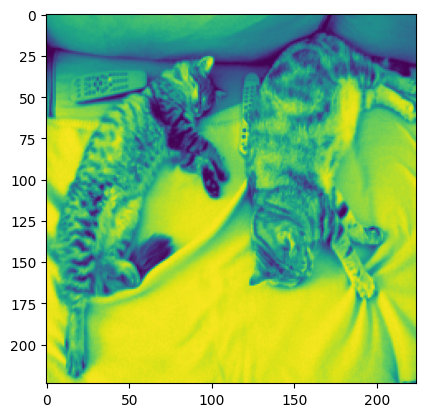

In [35]:
img = image_processor(image).pixel_values[0]
plt.imshow(img[0])
img.shape

## Embedding image

In [12]:
# transform image to tensor
x = torch.tensor(img)#.permute(1, 2, 0)
x.shape

torch.Size([3, 224, 224])

In [16]:
# do linear projection
projection_layer = nn.Conv2d(n_channels, dim, kernel_size=patch_size, stride=patch_size)
x_proj = projection_layer(x)
x_proj.shape

torch.Size([768, 14, 14])

In [17]:
print(weights['embeddings.patch_embeddings.projection.weight'].shape, weights['embeddings.patch_embeddings.projection.bias'].shape)
print(projection_layer.weight.shape, projection_layer.bias.shape)

KeyError: 'embeddings.patch_embeddings.projection.weight'

In [209]:
# reshape to 1D
x_proj_reshaped = x_proj.reshape(-1, dim, image_size//patch_size * image_size//patch_size)
x_proj_reshaped.shape


torch.Size([1, 768, 196])

In [210]:
# move embedding axis as last
x_proj_reshaped = x_proj_reshaped.permute(0, 2, 1)
x_proj_reshaped.shape

torch.Size([1, 196, 768])

## CLS token

In [262]:
cls_token = torch.rand(1, 1, dim)
print(cls_token.shape, x_proj_reshaped.shape)
x_proj_reshaped = torch.cat((cls_token, x_proj_reshaped), dim=1)
x_proj_reshaped.shape

torch.Size([1, 1, 768]) torch.Size([1, 196, 768])


torch.Size([1, 197, 768])

## Positional embedding

In [206]:
# create positional embeddings
pos_enc = nn.Parameter(torch.rand(1, image_size//patch_size * image_size//patch_size, dim))
print(pos_enc.shape)
print(weights["embeddings.position_embeddings"].shape)

torch.Size([1, 196, 768])
torch.Size([1, 197, 768])


## Single head self attention (SA)

In [106]:
head_dim = dim // n_heads

q_weights = nn.Linear(dim, head_dim)
k_weights = nn.Linear(dim, head_dim)
v_weights = nn.Linear(dim, head_dim)

q = q_weights(x_proj_reshaped)
k = k_weights(x_proj_reshaped)
v = v_weights(x_proj_reshaped)

q.shape, k.shape, v.shape


(torch.Size([1, 196, 64]), torch.Size([1, 196, 64]), torch.Size([1, 196, 64]))

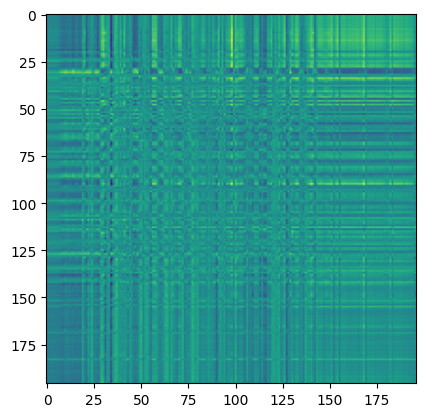

torch.Size([1, 196, 196])

In [129]:
# compute attention matrix
att_mat = torch.matmul(q, k.transpose(1, 2)) / np.sqrt(head_dim)
plt.imshow(att_mat[0].detach().numpy()); plt.show()
att_mat.shape

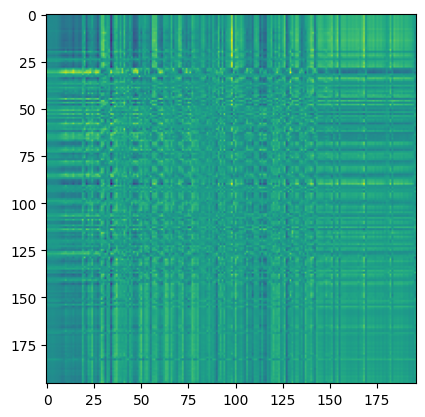

tensor([[1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0

In [130]:
# compute attention scores
att_scores = F.softmax(att_mat, dim=-1)
plt.imshow(att_scores[0].detach().numpy()); plt.show()
print(att_scores.sum(-1))
print(att_scores.shape)

In [131]:
# compute attention output
print(att_scores.shape, v.shape)
att_output = torch.matmul(att_scores, v)
print(att_output.shape)

torch.Size([1, 196, 196]) torch.Size([1, 196, 64])
torch.Size([1, 196, 64])


## Multi-head self attention (MSA)

In [191]:
head_dim * n_heads

768

In [219]:
# create q, k, v weights for all heads
q_weights = nn.Linear(dim, head_dim * n_heads) # dim x dim
k_weights = nn.Linear(dim, head_dim * n_heads)
v_weights = nn.Linear(dim, head_dim * n_heads)

print(q_weights.weight.shape, k_weights.weight.shape, v_weights.weight.shape)
print(
    weights["encoder.layer.0.attention.attention.query.weight"].shape,
    weights["encoder.layer.0.attention.attention.key.weight"].shape,
    weights["encoder.layer.0.attention.attention.value.weight"].shape
)

torch.Size([768, 768]) torch.Size([768, 768]) torch.Size([768, 768])
torch.Size([768, 768]) torch.Size([768, 768]) torch.Size([768, 768])


In [220]:
# create bias for q, k, v
print(q_weights.bias.shape, k_weights.bias.shape, v_weights.bias.shape)
print(
    weights["encoder.layer.0.attention.attention.query.bias"].shape,
    weights["encoder.layer.0.attention.attention.key.bias"].shape,
    weights["encoder.layer.0.attention.attention.value.bias"].shape
)



torch.Size([768]) torch.Size([768]) torch.Size([768])
torch.Size([768]) torch.Size([768]) torch.Size([768])


In [221]:
q = q_weights(x_proj_reshaped)
k = k_weights(x_proj_reshaped)
v = v_weights(x_proj_reshaped)
print(q.shape, k.shape, v.shape)

torch.Size([1, 196, 768]) torch.Size([1, 196, 768]) torch.Size([1, 196, 768])


In [197]:
# reshape to bsz, n_patches, n_heads, head_dim
q = q.reshape(q.shape[0], q.shape[1], n_heads, head_dim)
k = k.reshape(k.shape[0], k.shape[1], n_heads, head_dim)
v = v.reshape(v.shape[0], v.shape[1], n_heads, head_dim)

q.shape, k.shape, v.shape

(torch.Size([1, 196, 12, 64]),
 torch.Size([1, 196, 12, 64]),
 torch.Size([1, 196, 12, 64]))

In [136]:
# reorder axes from bsz, n_patches, n_heads, head_dim to bsz, n_heads, n_patches, head_dim
q = q.permute(0, 2, 1, 3)
k = k.permute(0, 2, 1, 3)
v = v.permute(0, 2, 1, 3)

q.shape, k.shape, v.shape

(torch.Size([1, 12, 196, 64]),
 torch.Size([1, 12, 196, 64]),
 torch.Size([1, 12, 196, 64]))

In [140]:
# compute attention matrix
att_mat = torch.matmul(q, k.transpose(2, 3)) / np.sqrt(head_dim)
# plt.imshow(att_mat[0, 0].detach().numpy()); plt.show()
att_mat.shape

torch.Size([1, 12, 196, 196])

In [144]:
# compute attention scores
att_scores = F.softmax(att_mat, dim=-1)
# plt.imshow(att_scores[0, 0].detach().numpy()); plt.show()
print(att_scores.sum(-1))
print(att_scores.shape)

tensor([[[1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 1.0000,  ..., 1.0000, 1.0000, 1.0000]]],
       grad_fn=<SumBackward1>)
torch.Size([1, 12, 196, 196])


In [150]:
# compute attention output
print(att_scores.shape, v.shape)
att_output = torch.matmul(att_scores, v)
print(att_output.shape)

torch.Size([1, 12, 196, 196]) torch.Size([1, 12, 196, 64])
torch.Size([1, 12, 196, 64])


In [151]:
# reorder axes from bsz, n_heads, n_patches, head_dim to bsz, n_patches, n_heads, head_dim
att_output = att_output.permute(0, 2, 1, 3)
att_output.shape

torch.Size([1, 196, 12, 64])

In [152]:
# reshape to bsz, n_patches, dim
att_output = att_output.reshape(att_output.shape[0], att_output.shape[1], dim)
att_output.shape

torch.Size([1, 196, 768])

In [228]:
weights['layernorm.bias'].shape

torch.Size([768])

In [242]:
model

ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTSdpaAttention(
          (attention): ViTSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=768, out_features=3072, bias=True)
          (intermediate_act_fn): GELUAct

In [157]:
list(weights.keys())

['embeddings.cls_token',
 'embeddings.position_embeddings',
 'embeddings.patch_embeddings.projection.weight',
 'embeddings.patch_embeddings.projection.bias',
 'encoder.layer.0.attention.attention.query.weight',
 'encoder.layer.0.attention.attention.query.bias',
 'encoder.layer.0.attention.attention.key.weight',
 'encoder.layer.0.attention.attention.key.bias',
 'encoder.layer.0.attention.attention.value.weight',
 'encoder.layer.0.attention.attention.value.bias',
 'encoder.layer.0.attention.output.dense.weight',
 'encoder.layer.0.attention.output.dense.bias',
 'encoder.layer.0.intermediate.dense.weight',
 'encoder.layer.0.intermediate.dense.bias',
 'encoder.layer.0.output.dense.weight',
 'encoder.layer.0.output.dense.bias',
 'encoder.layer.0.layernorm_before.weight',
 'encoder.layer.0.layernorm_before.bias',
 'encoder.layer.0.layernorm_after.weight',
 'encoder.layer.0.layernorm_after.bias',
 'encoder.layer.1.attention.attention.query.weight',
 'encoder.layer.1.attention.attention.query.b

In [168]:
# get model param count
n_params = sum([p.numel() for p in model.parameters()])
n_params

86389248

## Layer Normalization (LN)

In [176]:

ln_after = nn.LayerNorm(dim, eps=norm_eps)

print(ln_after.weight.shape)
print(weights["encoder.layer.8.layernorm_after.weight"].shape)

att_out_after_ln = ln_after(att_output)
att_out_after_ln.shape


torch.Size([768])
torch.Size([768])


torch.Size([1, 196, 768])

## Fully connected layer after attention

In [183]:
FN1 = nn.Linear(dim, fc_intermediate_size)
FN2 = nn.Linear(fc_intermediate_size, dim)
act = nn.GELU()

print(att_out_after_ln.shape)
fc_inter = act(FN1(att_out_after_ln))
print(fc_inter.shape)
fc_out = act(FN2(fc_inter))
print(fc_out.shape)


torch.Size([1, 196, 768])
torch.Size([1, 196, 3072])
torch.Size([1, 196, 768])


# Combine everything together

In [36]:
class ViT(nn.Module):
    def __init__(self, dim, n_channels, n_layers, n_heads, image_size, patch_size, fc_intermediate_size, norm_eps):
        super(ViT, self).__init__()
        self.dim = dim
        self.n_channels = n_channels
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.image_size = image_size
        self.patch_size = patch_size
        self.fc_intermediate_size = fc_intermediate_size
        self.norm_eps = norm_eps
        self.head_dim = dim // n_heads
        self.n_patches = image_size // patch_size * image_size // patch_size

        self.projection_layer = nn.Conv2d(n_channels, dim, kernel_size=patch_size, stride=patch_size)
        self.pos_enc = nn.Parameter(torch.rand(1, self.n_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.rand(1, 1, dim))
        
        # create torch array for storing layers
        self.layers = nn.ModuleDict()
        for i in range(n_layers):
            ln_before = nn.LayerNorm(dim, eps=self.norm_eps)

            q_layer = nn.Linear(dim, dim)
            k_layer = nn.Linear(dim, dim)
            v_layer = nn.Linear(dim, dim)
            att_fc_out = nn.Linear(dim, dim)
                      
            ln_after = nn.LayerNorm(dim, eps=self.norm_eps)
            fc1 = nn.Linear(dim, fc_intermediate_size)
            act1 = nn.GELU()
            fc2 = nn.Linear(fc_intermediate_size, dim)
            act2 = nn.GELU()

            self.layers[f"layer_{i}_ln_before"] = ln_before
            self.layers[f"layer_{i}_q"] = q_layer
            self.layers[f"layer_{i}_k"] = k_layer
            self.layers[f"layer_{i}_v"] = v_layer
            self.layers[f"layer_{i}_att_fc_out"] = att_fc_out
            self.layers[f"layer_{i}_ln_after"] = ln_after
            self.layers[f"layer_{i}_FN1"] = fc1
            self.layers[f"layer_{i}_act1"] = act1
            self.layers[f"layer_{i}_FN2"] = fc2
            self.layers[f"layer_{i}_act2"] = act2

        self.out_ln = nn.LayerNorm(dim, eps=self.norm_eps)
        # self.out_fc = nn.Linear(dim, dim)
        self.out_fc = nn.Linear(dim, 1000)
        self.out_act = nn.Tanh()

    def load_weights(self, weights, prefix=""):
        self.cls_token.data = weights[f"{prefix}embeddings.cls_token"].data
        self.pos_enc.data = weights[f"{prefix}embeddings.position_embeddings"].data
        self.projection_layer.weight.data = weights[f"{prefix}embeddings.patch_embeddings.projection.weight"].data
        self.projection_layer.bias.data = weights[f"{prefix}embeddings.patch_embeddings.projection.bias"].data

        for i in range(self.n_layers):
            self.layers[f"layer_{i}_ln_before"].weight.data = weights[f"{prefix}encoder.layer.{i}.layernorm_before.weight"].data
            self.layers[f"layer_{i}_ln_before"].bias.data = weights[f"{prefix}encoder.layer.{i}.layernorm_before.bias"].data
            self.layers[f"layer_{i}_q"].weight.data = weights[f"{prefix}encoder.layer.{i}.attention.attention.query.weight"].data
            self.layers[f"layer_{i}_q"].bias.data = weights[f"{prefix}encoder.layer.{i}.attention.attention.query.bias"].data
            self.layers[f"layer_{i}_k"].weight.data = weights[f"{prefix}encoder.layer.{i}.attention.attention.key.weight"].data
            self.layers[f"layer_{i}_k"].bias.data = weights[f"{prefix}encoder.layer.{i}.attention.attention.key.bias"].data
            self.layers[f"layer_{i}_v"].weight.data = weights[f"{prefix}encoder.layer.{i}.attention.attention.value.weight"].data
            self.layers[f"layer_{i}_v"].bias.data = weights[f"{prefix}encoder.layer.{i}.attention.attention.value.bias"].data
            self.layers[f"layer_{i}_att_fc_out"].weight.data = weights[f"{prefix}encoder.layer.{i}.attention.output.dense.weight"].data
            self.layers[f"layer_{i}_att_fc_out"].bias.data = weights[f"{prefix}encoder.layer.{i}.attention.output.dense.bias"].data
            self.layers[f"layer_{i}_ln_after"].weight.data = weights[f"{prefix}encoder.layer.{i}.layernorm_after.weight"].data
            self.layers[f"layer_{i}_ln_after"].bias.data = weights[f"{prefix}encoder.layer.{i}.layernorm_after.bias"].data
            self.layers[f"layer_{i}_FN1"].weight.data = weights[f"{prefix}encoder.layer.{i}.intermediate.dense.weight"].data
            self.layers[f"layer_{i}_FN1"].bias.data = weights[f"{prefix}encoder.layer.{i}.intermediate.dense.bias"].data
            self.layers[f"layer_{i}_FN2"].weight.data = weights[f"{prefix}encoder.layer.{i}.output.dense.weight"].data
            self.layers[f"layer_{i}_FN2"].bias.data = weights[f"{prefix}encoder.layer.{i}.output.dense.bias"].data

        self.out_ln.weight.data = weights[f"{prefix}layernorm.weight"].data
        self.out_ln.bias.data = weights[f"{prefix}layernorm.bias"].data
        # self.out_fc.weight.data = weights["pooler.dense.weight"].data
        # self.out_fc.bias.data = weights["pooler.dense.bias"].data
        self.out_fc.weight.data = weights["classifier.weight"].data
        self.out_fc.bias.data = weights["classifier.bias"].data


    def forward(self, x):
        # patch encoding
        x = self.projection_layer(x)
        # reshape to shape (bsz, dim, n_patches)
        x = x.reshape(x.shape[0], self.dim, -1)
        # move embedding axis as last tp (bsz, n_patches, dim)
        x = x.permute(0, 2, 1)
        # append CLS token
        x = torch.cat([self.cls_token, x], dim=1)
        # add positional encoding
        x = x + self.pos_enc

        # perform MSA blocks
        for i in range(self.n_layers):
            # layer norm before
            ln_x = self.layers[f"layer_{i}_ln_before"](x)
            # compute query, key, values
            q = self.layers[f"layer_{i}_q"](ln_x)
            k = self.layers[f"layer_{i}_k"](ln_x)
            v = self.layers[f"layer_{i}_v"](ln_x)
            # reshape to bsz, n_patches, n_heads, head_dim and permute to bsz, n_heads, n_patches, head_dim
            q = q.reshape(q.shape[0], q.shape[1], self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            k = k.reshape(k.shape[0], k.shape[1], self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            v = v.reshape(v.shape[0], v.shape[1], self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            # compute attention matrix
            att_mat = torch.matmul(q, k.transpose(-2, -1)) / self.head_dim ** 0.5
            # compute attention scores
            att_scores = F.softmax(att_mat, dim=-1)
            # compute attention output
            att_output = torch.matmul(att_scores, v)
            # reorder axes from bsz, n_heads, n_patches, head_dim to bsz, n_patches, n_heads, head_dim
            att_output = att_output.permute(0, 2, 1, 3)
            # reshape to bsz, n_patches, dim
            att_output = att_output.reshape(att_output.shape[0], att_output.shape[1], self.dim)
            # fully-connected layer
            att_fc_output = self.layers[f"layer_{i}_att_fc_out"](att_output)
            # add to residual
            x = x + att_fc_output
            # layer norm after
            ln_x = self.layers[f"layer_{i}_ln_after"](x)
            # fully-connected layers
            fc_inter = self.layers[f"layer_{i}_act1"](
                self.layers[f"layer_{i}_FN1"](ln_x))
            fc_out = self.layers[f"layer_{i}_FN2"](fc_inter)
            # add to residual
            x = x + fc_out

        # layer norm after
        x = self.out_ln(x)
        # fully-connected layers
        x = self.out_fc(x)
        # x = self.out_act(x)
        return x

custom_model = ViT(
    dim=dim,
    n_channels=n_channels,
    n_layers=n_layers,
    n_heads=n_heads,
    image_size=image_size,
    patch_size=patch_size,
    fc_intermediate_size=fc_intermediate_size,
    norm_eps=norm_eps
)

# get model param count
n_params_custom = sum([p.numel() for p in custom_model.parameters()])
n_params_custom


86567656

In [37]:
custom_model.load_weights(weights, prefix="vit.")

In [38]:
n_params_orig = sum([p.numel() for p in model.parameters()])
print(n_params_orig - n_params_custom)

0


In [42]:
custom_model.eval()
img_tensor = image_processor(image, return_tensors="pt").pixel_values

logits = custom_model(img_tensor)[0,0]
# get probability distribution
probs = F.softmax(logits, dim=-1)
# get predicted label
predicted_label = probs.argmax(-1).item()
print(model.config.id2label[predicted_label])


Egyptian cat


In [16]:
from transformers import ViTModel, ViTConfig


# Load the model


# Define the hook function
def print_hook(module, input, output):
    # print(f"{module.__class__.__name__} output shape: {output.shape}")
    print(f"{module.__class__.__name__} output: {output[0]}")

# Function to add hooks
def add_hooks(model):
    for name, module in model.named_modules():#sure this matches the ViTSelfAttention class
        # module.register_forward_hook(print_hook)
        # remove hooks
        module._forward_hooks.clear()

# Add hooks
add_hooks(model)



model.eval()
model(img_tensor).pooler_output

tensor([[ 5.8399e-02, -3.0683e-01,  3.1213e-01, -1.1009e-01, -1.4752e-01,
          4.9735e-01, -1.5786e-01,  4.8658e-01, -4.6255e-01,  2.4344e-01,
          2.9942e-02,  2.8738e-01, -4.8914e-01, -9.9518e-03, -2.8943e-01,
          3.1443e-01, -6.2883e-02, -2.6637e-01, -3.9652e-01,  2.9896e-01,
          2.1507e-01, -1.9265e-01,  1.1786e-01,  2.5995e-01,  3.5440e-01,
         -3.7968e-01,  4.8320e-01, -3.5686e-01,  2.3996e-01, -8.0731e-01,
          1.1701e-02,  4.9429e-01,  6.9714e-01,  5.2732e-01,  6.8406e-01,
          5.4112e-01, -3.6567e-01, -5.8525e-02,  2.2564e-01,  2.7409e-01,
          4.5724e-01, -4.2382e-01, -4.7543e-02,  3.8201e-01,  1.1637e-01,
         -6.0073e-01, -6.1237e-01, -2.9060e-01, -1.6196e-01, -2.2600e-01,
          3.3057e-01, -4.6795e-01, -1.0904e-01, -1.8052e-01, -1.9760e-01,
          1.6378e-01,  4.4932e-01,  3.2078e-01, -8.4977e-03,  2.4506e-01,
          4.4046e-01, -4.5339e-01, -5.6663e-01, -1.7683e-01, -5.0688e-01,
         -3.8825e-01, -6.4027e-02,  4.

In [20]:
# evaluate if outputs are almost equal
torch.allclose(model(img_tensor).pooler_output, custom_model(img_tensor)[0,0], atol=1e-7)

False

# SigLip weights from PaliGemma

In [2]:
from transformers import AutoProcessor, PaliGemmaForConditionalGeneration

model_id = "google/paligemma-3b-mix-224"
pg_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id)
processor = AutoProcessor.from_pretrained(model_id)

c:\Users\lazar\miniconda3\envs\modern_nlp\lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\lazar\.cache\huggingface\hub\models--google--paligemma-3b-mix-224. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's acti


bee


In [8]:
prompt = "detect bee?"
image_file = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/bee.jpg?download=true"
raw_image = Image.open(requests.get(image_file, stream=True).raw)
inputs = processor(prompt, raw_image, return_tensors="pt")
output = pg_model.generate(**inputs, max_new_tokens=20)

print(processor.decode(output[0], skip_special_tokens=True)[len(prompt):])


<loc0476><loc0455><loc0579><loc0512> bee


In [26]:
pg_model.config.vision_config

SiglipVisionConfig {
  "attention_dropout": 0.0,
  "hidden_act": "gelu_pytorch_tanh",
  "hidden_size": 1152,
  "image_size": 224,
  "intermediate_size": 4304,
  "layer_norm_eps": 1e-06,
  "model_type": "siglip_vision_model",
  "num_attention_heads": 16,
  "num_channels": 3,
  "num_hidden_layers": 27,
  "num_image_tokens": 256,
  "patch_size": 14,
  "projection_dim": 2048,
  "projector_hidden_act": "gelu_fast",
  "transformers_version": "4.41.0",
  "vision_use_head": false
}

In [32]:
config

ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "tench, Tinca tinca",
    "1": "goldfish, Carassius auratus",
    "2": "great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias",
    "3": "tiger shark, Galeocerdo cuvieri",
    "4": "hammerhead, hammerhead shark",
    "5": "electric ray, crampfish, numbfish, torpedo",
    "6": "stingray",
    "7": "cock",
    "8": "hen",
    "9": "ostrich, Struthio camelus",
    "10": "brambling, Fringilla montifringilla",
    "11": "goldfinch, Carduelis carduelis",
    "12": "house finch, linnet, Carpodacus mexicanus",
    "13": "junco, snowbird",
    "14": "indigo bunting, indigo finch, indigo bird, Passerina cyanea",
    "15": "robin, American robin, Turdus migratorius",
    "16": "bulbul",
 

In [24]:
list(x for x in pg_model.state_dict().keys() if 'vision_tower' in x)

['vision_tower.vision_model.embeddings.patch_embedding.weight',
 'vision_tower.vision_model.embeddings.patch_embedding.bias',
 'vision_tower.vision_model.embeddings.position_embedding.weight',
 'vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.weight',
 'vision_tower.vision_model.encoder.layers.0.self_attn.k_proj.bias',
 'vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.weight',
 'vision_tower.vision_model.encoder.layers.0.self_attn.v_proj.bias',
 'vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.weight',
 'vision_tower.vision_model.encoder.layers.0.self_attn.q_proj.bias',
 'vision_tower.vision_model.encoder.layers.0.self_attn.out_proj.weight',
 'vision_tower.vision_model.encoder.layers.0.self_attn.out_proj.bias',
 'vision_tower.vision_model.encoder.layers.0.layer_norm1.weight',
 'vision_tower.vision_model.encoder.layers.0.layer_norm1.bias',
 'vision_tower.vision_model.encoder.layers.0.mlp.fc1.weight',
 'vision_tower.vision_model.encoder.layers.0.mlp.fc

In [35]:
pg_model.vision_tower.vision_model

SiglipVisionTransformer(
  (embeddings): SiglipVisionEmbeddings(
    (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
    (position_embedding): Embedding(256, 1152)
  )
  (encoder): SiglipEncoder(
    (layers): ModuleList(
      (0-26): 27 x SiglipEncoderLayer(
        (self_attn): SiglipAttention(
          (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
        )
        (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
        (mlp): SiglipMLP(
          (activation_fn): PytorchGELUTanh()
          (fc1): Linear(in_features=1152, out_features=4304, bias=True)
          (fc2): Linear(in_features=4304, out_features=1152, bias=True)
        )
        (layer_norm2): LayerNorm((1152,), eps

In [85]:
# Only differences to ViT:
#  - CLS token is not added
#  - There is no output layer (either FC or classification layer)

# We also need to change the load_weights method to match the SigLip model weights' keys

class SigLip(nn.Module):
    def __init__(self, dim, n_channels, n_layers, n_heads, image_size, patch_size, fc_intermediate_size, norm_eps):
        super(SigLip, self).__init__()
        self.dim = dim
        self.n_channels = n_channels
        self.n_layers = n_layers
        self.n_heads = n_heads
        self.image_size = image_size
        self.patch_size = patch_size
        self.fc_intermediate_size = fc_intermediate_size
        self.norm_eps = norm_eps
        self.head_dim = dim // n_heads
        self.n_patches = image_size // patch_size * image_size // patch_size

        self.projection_layer = nn.Conv2d(n_channels, dim, kernel_size=patch_size, stride=patch_size)
        # self.pos_enc = nn.Parameter(torch.rand(1, self.n_patches + 1, dim))
        # self.cls_token = nn.Parameter(torch.rand(1, 1, dim))
        self.pos_enc = nn.Parameter(torch.rand(1, self.n_patches, dim))
        
        # create torch array for storing layers
        self.layers = nn.ModuleDict()
        for i in range(n_layers):
            ln_before = nn.LayerNorm(dim, eps=self.norm_eps)

            q_layer = nn.Linear(dim, dim)
            k_layer = nn.Linear(dim, dim)
            v_layer = nn.Linear(dim, dim)
            att_fc_out = nn.Linear(dim, dim)
                      
            ln_after = nn.LayerNorm(dim, eps=self.norm_eps)
            fc1 = nn.Linear(dim, fc_intermediate_size)
            act1 = nn.GELU(approximate='tanh')
            fc2 = nn.Linear(fc_intermediate_size, dim)
            act2 = nn.GELU(approximate='tanh')

            self.layers[f"layer_{i}_ln_before"] = ln_before
            self.layers[f"layer_{i}_q"] = q_layer
            self.layers[f"layer_{i}_k"] = k_layer
            self.layers[f"layer_{i}_v"] = v_layer
            self.layers[f"layer_{i}_att_fc_out"] = att_fc_out
            self.layers[f"layer_{i}_ln_after"] = ln_after
            self.layers[f"layer_{i}_FN1"] = fc1
            self.layers[f"layer_{i}_act1"] = act1
            self.layers[f"layer_{i}_FN2"] = fc2
            self.layers[f"layer_{i}_act2"] = act2

        self.out_ln = nn.LayerNorm(dim, eps=self.norm_eps)
        # self.out_fc = nn.Linear(dim, dim)
        # self.out_fc = nn.Linear(dim, 1000)
        # self.out_act = nn.Tanh()


    def load_weights(self, weights, prefix=""):
        # Load the embeddings
        self.pos_enc.data = weights[f"{prefix}embeddings.position_embedding.weight"].data
        self.projection_layer.weight.data = weights[f"{prefix}embeddings.patch_embedding.weight"].data
        self.projection_layer.bias.data = weights[f"{prefix}embeddings.patch_embedding.bias"].data

        # Loop over each layer in the model
        for i in range(self.n_layers):
            # Layer normalization before self attention
            self.layers[f"layer_{i}_ln_before"].weight.data = weights[f"{prefix}encoder.layers.{i}.layer_norm1.weight"].data
            self.layers[f"layer_{i}_ln_before"].bias.data = weights[f"{prefix}encoder.layers.{i}.layer_norm1.bias"].data

            # Self attention sub-layers (Query, Key, Value)
            for part in ['q', 'k', 'v']:
                self.layers[f"layer_{i}_{part}"].weight.data = weights[f"{prefix}encoder.layers.{i}.self_attn.{part}_proj.weight"].data
                self.layers[f"layer_{i}_{part}"].bias.data = weights[f"{prefix}encoder.layers.{i}.self_attn.{part}_proj.bias"].data

            # Output projection from self attention
            self.layers[f"layer_{i}_att_fc_out"].weight.data = weights[f"{prefix}encoder.layers.{i}.self_attn.out_proj.weight"].data
            self.layers[f"layer_{i}_att_fc_out"].bias.data = weights[f"{prefix}encoder.layers.{i}.self_attn.out_proj.bias"].data

            # Layer normalization after self attention
            self.layers[f"layer_{i}_ln_after"].weight.data = weights[f"{prefix}encoder.layers.{i}.layer_norm2.weight"].data
            self.layers[f"layer_{i}_ln_after"].bias.data = weights[f"{prefix}encoder.layers.{i}.layer_norm2.bias"].data

            # Feedforward network layers
            self.layers[f"layer_{i}_FN1"].weight.data = weights[f"{prefix}encoder.layers.{i}.mlp.fc1.weight"].data
            self.layers[f"layer_{i}_FN1"].bias.data = weights[f"{prefix}encoder.layers.{i}.mlp.fc1.bias"].data
            self.layers[f"layer_{i}_FN2"].weight.data = weights[f"{prefix}encoder.layers.{i}.mlp.fc2.weight"].data
            self.layers[f"layer_{i}_FN2"].bias.data = weights[f"{prefix}encoder.layers.{i}.mlp.fc2.bias"].data

        # Load final layer normalization weights
        self.out_ln.weight.data = weights[f"{prefix}post_layernorm.weight"].data
        self.out_ln.bias.data = weights[f"{prefix}post_layernorm.bias"].data


    def forward(self, x):
        # patch encoding
        x = self.projection_layer(x)
        # reshape to shape (bsz, dim, n_patches)
        x = x.reshape(x.shape[0], self.dim, -1)
        # move embedding axis as last tp (bsz, n_patches, dim)
        x = x.permute(0, 2, 1)
        # append CLS token
        # x = torch.cat([self.cls_token, x], dim=1)
        # add positional encoding
        x = x + self.pos_enc

        # perform MSA blocks
        for i in range(self.n_layers):
            # layer norm before
            ln_x = self.layers[f"layer_{i}_ln_before"](x)
            # compute query, key, values
            q = self.layers[f"layer_{i}_q"](ln_x)
            k = self.layers[f"layer_{i}_k"](ln_x)
            v = self.layers[f"layer_{i}_v"](ln_x)
            # reshape to bsz, n_patches, n_heads, head_dim and permute to bsz, n_heads, n_patches, head_dim
            q = q.reshape(q.shape[0], q.shape[1], self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            k = k.reshape(k.shape[0], k.shape[1], self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            v = v.reshape(v.shape[0], v.shape[1], self.n_heads, self.head_dim).permute(0, 2, 1, 3)
            # compute attention matrix
            att_mat = torch.matmul(q, k.transpose(-2, -1)) / self.head_dim ** 0.5
            # compute attention scores
            att_scores = F.softmax(att_mat, dim=-1)
            # compute attention output
            att_output = torch.matmul(att_scores, v)
            # reorder axes from bsz, n_heads, n_patches, head_dim to bsz, n_patches, n_heads, head_dim
            att_output = att_output.permute(0, 2, 1, 3)
            # reshape to bsz, n_patches, dim
            att_output = att_output.reshape(att_output.shape[0], att_output.shape[1], self.dim)
            # fully-connected layer
            att_fc_output = self.layers[f"layer_{i}_att_fc_out"](att_output)
            # add to residual
            x = x + att_fc_output
            # layer norm after
            ln_x = self.layers[f"layer_{i}_ln_after"](x)
            # fully-connected layers
            fc_inter = self.layers[f"layer_{i}_act1"](
                self.layers[f"layer_{i}_FN1"](ln_x))
            fc_out = self.layers[f"layer_{i}_FN2"](fc_inter)
            # add to residual
            x = x + fc_out

        # layer norm after
        x = self.out_ln(x)
        # fully-connected layers
        # x = self.out_fc(x)
        # x = self.out_act(x)
        return x

custom_model = SigLip(
    dim=pg_model.config.vision_config.hidden_size,
    n_channels=pg_model.config.vision_config.num_channels,
    n_layers=pg_model.config.vision_config.num_hidden_layers,
    n_heads=pg_model.config.vision_config.num_attention_heads,
    image_size=pg_model.config.vision_config.image_size,
    patch_size=pg_model.config.vision_config.patch_size,
    fc_intermediate_size=pg_model.config.vision_config.intermediate_size,
    norm_eps=pg_model.config.vision_config.layer_norm_eps
)

# get model param count
n_params_custom = sum([p.numel() for p in custom_model.parameters()])
n_params_custom


412442352

In [86]:
# print pg_model 
n_params_orig = sum([p.numel() for p in pg_model.vision_tower.vision_model.parameters()])
print(n_params_orig - n_params_custom)

0


In [87]:
pg_model.vision_tower.vision_model

SiglipVisionTransformer(
  (embeddings): SiglipVisionEmbeddings(
    (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
    (position_embedding): Embedding(256, 1152)
  )
  (encoder): SiglipEncoder(
    (layers): ModuleList(
      (0-26): 27 x SiglipEncoderLayer(
        (self_attn): SiglipAttention(
          (k_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (v_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (q_proj): Linear(in_features=1152, out_features=1152, bias=True)
          (out_proj): Linear(in_features=1152, out_features=1152, bias=True)
        )
        (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
        (mlp): SiglipMLP(
          (activation_fn): PytorchGELUTanh()
          (fc1): Linear(in_features=1152, out_features=4304, bias=True)
          (fc2): Linear(in_features=4304, out_features=1152, bias=True)
        )
        (layer_norm2): LayerNorm((1152,), eps

In [88]:
custom_model.load_weights(pg_model.vision_tower.vision_model.state_dict())

In [89]:
img = processor.image_processor(raw_image).pixel_values[0]
img = torch.tensor(img)
img.shape

torch.Size([3, 224, 224])

In [90]:
with torch.no_grad():
    gt_out = pg_model.vision_tower.vision_model(img.unsqueeze(0)).last_hidden_state

print(gt_out)
    

tensor([[[-0.5767,  0.9453,  2.6301,  ...,  2.5150, -0.8549,  0.1816],
         [-0.3470, -0.8924, -0.5727,  ...,  0.2510,  1.0338,  0.2120],
         [-0.7428, -0.6254,  1.5499,  ..., -1.2788,  0.1796,  0.8002],
         ...,
         [ 0.0531, -0.3076, -0.3051,  ...,  0.1847,  0.1706,  0.1375],
         [ 0.1583,  0.5445,  1.0975,  ..., -0.0445,  0.3151,  0.4949],
         [-0.1663, -0.1359,  0.4355,  ..., -0.6769,  0.4707,  0.7764]]])


In [91]:
with torch.no_grad():
    custom_out = custom_model(img.unsqueeze(0))

print(custom_out)

tensor([[[-0.5767,  0.9453,  2.6301,  ...,  2.5150, -0.8549,  0.1816],
         [-0.3470, -0.8924, -0.5727,  ...,  0.2510,  1.0338,  0.2120],
         [-0.7428, -0.6254,  1.5499,  ..., -1.2788,  0.1796,  0.8002],
         ...,
         [ 0.0531, -0.3076, -0.3051,  ...,  0.1847,  0.1706,  0.1375],
         [ 0.1583,  0.5445,  1.0975,  ..., -0.0445,  0.3151,  0.4949],
         [-0.1663, -0.1359,  0.4355,  ..., -0.6769,  0.4707,  0.7764]]])


In [96]:
# evaluate if outputs are almost equal
torch.allclose(gt_out, custom_out, atol=1e-4)

True